In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import scipy.stats as ss
import collections
import corner
import seaborn as sns
%matplotlib inline

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [368]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance)

In [5]:
df=pd.read_csv("NED26.05.1-D-12.1.0-20160501.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])]
df=df[np.isfinite(df.err)]

In [6]:
#df=df[df['D (Mpc)']>35]
#df=df[df['D (Mpc)']<500]


In [7]:
df.size

1328280

In [8]:
meth=[]
ndat=[]
for i in np.unique(df.Method)[:-3]:
    df2=df[df.Method==i]
    df1=df[df.Method=='Tully-Fisher']
    meth+=[i]
    ndat+=[df2.shape[0]]
info=pd.DataFrame({'method':meth,'nrows':ndat})
info.head()

,method,nrows
0,AGB,2
1,AGN time lag,32
2,B Stars,2
3,BL Lac Luminosity,14
4,Black Hole,17


In [12]:
namelist=list(df1['Galaxy ID']) # list of galaxies
counter=collections.Counter(namelist) # count measurements p. galaxy
# select galaxies with a minimum number of measurements
ulist=[]
nmeas=5
for i in counter.keys():
    if counter[i]>nmeas:
        ulist+=[i]
dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # short dataframe
disterr=0.461*dfs['D (Mpc)']*dfs.err 
len(ulist)

3094

In [375]:
%%time
nbins=1000 # 
names=[]
em=[] # 0
bootp50=[] #1
bootsig=[] #2
derr=[] #3
dmean=[] #4
rmserr=[] #5
dboot=[] #6
wstd=[]
for i in ulist:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    names+=[i]
    em+=[len(dummy)]
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))]
    booterr=np.percentile(tli, 84,axis=0)/1e6-np.percentile(tli, 16,axis=0)/1e6
    bootmean=np.mean(tli,axis=0) # rms -- is it useful?
    dumerr=disterr[dfilter]
    wstd+=[weighted_std(dummy['D (Mpc)'],dumerr)]
    derr+=[dumerr.mean()] # average reported error (Delta) -- is it useful?
    bootp50+=[np.mean(booterr)] # mean bootstrap error
    bootsig+=[(np.percentile(booterr, 84)-np.percentile(booterr, 16))] # the error of the error
    dmean+=[dummy['D (Mpc)'].mean()] # average reported distance (D) 5 here, 6 in bootstrap sampling.ipynb
#    rmserr+=[np.linalg.norm(dumerr/dummy['D (Mpc)'])*dmean] # rms error (D)
    dboot+=[np.mean(bootmean)/1e6] # bootstrap mean D

CPU times: user 15.2 s, sys: 0 ns, total: 15.2 s
Wall time: 15.3 s


### El Gran Modelo

Funciona a nmeas > 14 (337 galaxias), mientras que el independiente funciona a 56 galaxias - por eso nos gusta. Lo malo es que depende de sigma_sigma y que tiene muchos parametros. Lo bueno (?) es que no depende de wstd.

$$  \sigma_B = o\sigma_\sigma^2+gD_{50}^2+n\sigma_\sigma D_{50}+m D_{50} +f\sigma_\sigma+b $$

In [569]:
filt=np.array(em)>14
filt.sum()

337

In [570]:
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
z=np.array(wstd)[filt]
yerr=np.array(bootsig)[filt]
ydel=yerr

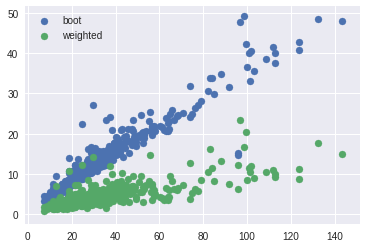

In [571]:
# This shows underprediction of errors :D ***KEEP***
plt.scatter(x,y,label="boot")
plt.scatter(x,z,label="weighted")
plt.legend()

In [572]:
# Likelihood
def lnlike(theta, x, y,yerr,ydel):
    m ,b,n,f,o,g = theta
    model = m * x +b+n*ydel*x+f*ydel+o*ydel**2+g*x**2 # model equation
    inv_sigma2 = 1.0/((yerr)**2) # weighted by the GMM-fitted sigma
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2))) 
# Priors
def lnprior(theta):
    m, b,n,f,o,g = theta
    if -2 < m < 2 and -20 < b < 20 and  -1 < n < 1 and -10 < f < 10 and -10 < o < 10 and -10 < g < 10:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob(theta, x, y,yerr,ydel):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr,ydel)

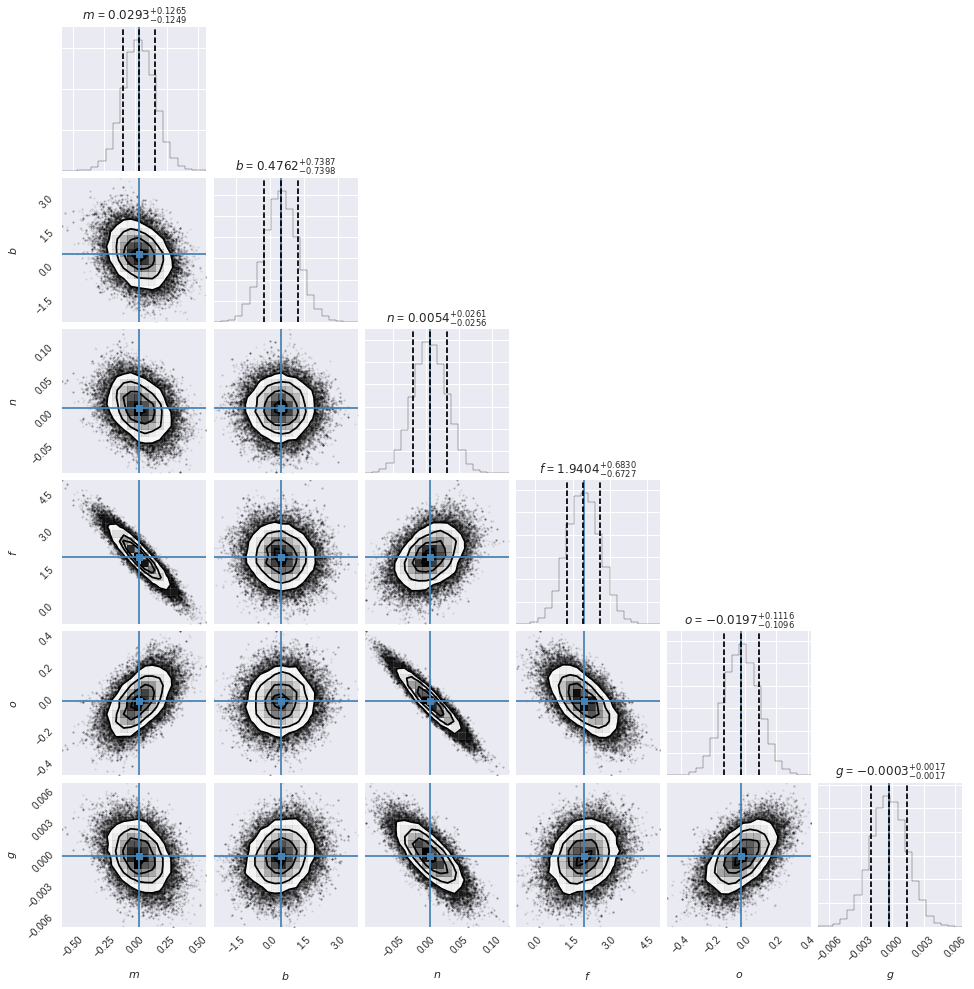

In [573]:
# This block uses the emcee MCMC sampler to estimate the posterior probability
# 1. Guess the starting places for the walkers from a maximum likelihood fit
nll = lambda *args: -lnlike(*args)
argum=(x, y,yerr,ydel)
result = op.minimize(nll, [1.]*6, args=argum)
m_ml, b_ml,n_ml,f_ml,o_ml,g_ml= result["x"]
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=argum) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$n$","$f$","$o$","$g$"],
                      truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

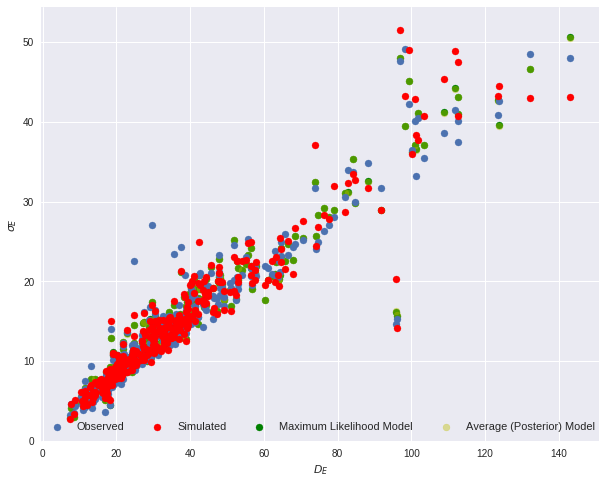

In [574]:
plt.figure(figsize=(10,8))

AAA=samples[np.random.randint(len(samples), size=len(x))]
y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*ydel*x+AAA[:,3]*ydel+AAA[:,4]*ydel**2+AAA[:,5]*x**2
y_ml=m_ml*x+b_ml+n_ml*ydel*x+f_ml*ydel+o_ml*ydel**2+g_ml*x**2
y_me=meanest[0]*x+meanest[1]+meanest[2]*ydel*x+meanest[3]*ydel+meanest[4]*ydel**2+meanest[5]*x**2
plml = plt.scatter(x,y_ml,c='g')
plme = plt.scatter(x,y_me,c='y',alpha=0.4)
plobs = plt.scatter(x,y)
plsim = plt.scatter(x,y_sim,c='r')
#plt.scatter(x,w,c='k')
plt.xlabel(r"$D_E$")
plt.ylabel(r"$\sigma_E$")
plt.legend((plobs, plsim, plml, plme),
           ('Observed', 'Simulated', 'Maximum Likelihood Model', 'Average (Posterior) Model'),
           scatterpoints=1,
           loc='lower center',
           ncol=4,
           fontsize=11)

plt.show()

Rejection rate (%): 0.19437709155762178
Bayesian p-value: 0.106907400357


(0, 73.147212348240572)

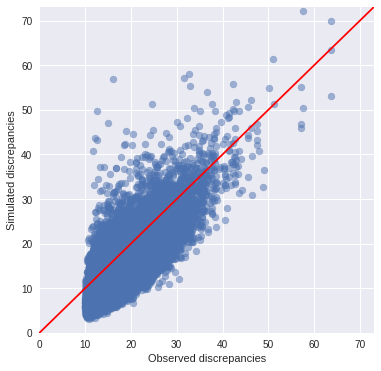

In [575]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
for m,b,n,f,o,g in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*ydel*x+AAA[:,3]*ydel+AAA[:,4]*ydel**2+AAA[:,5]*x**2 # create a synthetic dataset
    yexp=m*x+b+n*ydel*x+f*ydel+o*ydel**2+g*x**2 # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

### Resultados
- Cuando nmeas > 14 el p es bueno, pero para nmeas > 13 ya es malo. Guardar p, nmeas, ngal
- Con el minimo nmeas (14) no se logra independencia de sigma_sigma (sigma_sigma_indep.ipynb)
- Funciona para nmeas > 20 con modelo lineal y yerr = f*x y tambien para sigma_b=pol(x,3) y yerr cuadrático -> el great model se va dañando --> señal de que modelos más simples funcionan
- No funciona cuando yerr es función de y (igual que en sigma_sigma_indep) - codigo en ysigma_sigma_indep.ipynb
- No funciona cuando el peso se toma como 1/yerr y yerr es función de y (sysigma_sigma_indep.ipynb)
- No funciona cuando el peso se toma como 1/yerr y yerr es función de x (ssigma_sigma_indep.ipynb)
- MCMC falla para modelos polinomicos independientes con npol > 3 casi con cualquier yerr
- Para y=mx+b y yerr = wstd y w=1/(yerr^2+(f*y)^2)  no funciona el modelo independiente de sigma_sigma (para w=1/sqrt funciona aun peor)
- Para y=m*x+b+g*wstd y yerr = wstd o w=1/(yerr^2+(f*y)^2) o w=1/(yerr^2+(f*x)^2) no funciona, pero no esta mal tampoco (cerca) (para w=1/sqrt se aleja, parece ser en todos los casos) -> para nmeas > 19 obtenemos un buen p
- El modelo con yerr=wstd y w=1/yerr^2 funciona bien para predecir sigma_b. no es necesario añadir error en cuadratura para el peso estadistico. Quedarse con el. Esto propone que el error lo podemos calcular usando wstd como un estimador aun bajando nmeas (falta hacer esto) -> en la vida real nmeas es demasiado alto. Este modelo funciona muy muy bien si yerr = sigma_sigma, pero esa no es la idea (son demasiados inputs D_50, wstd, sigma_sigma).
    - Se puede intentar trabajar con pocos parametros y nmeas > 19
- El modelo para sigma_b^2=(rand)^2+(syst)^2 no funciona ni con w por cuadratura. Pero MCMC da un resultado, del cual se podrían sacar valores.
    - El analisis por cuadratura con rand=Ax+B no funciona para nada. Predice valores del error sistematico imaginarios.
    - Funciona mejor si asumimos que rand=Ax directamente, con yerr=sigma_sigma y w=1/yerr los resultados son muy consistentes para 4<nmeas<19. No dudo que pase un test AD (falta hacer esto).
    - El mismo modelo para aproximacion sugerida por S. Torres no funciona bien (rand tiene valores negativos a veces), pero considerando que sin aproximar nos va bien, no lo considero necesario.

### Modelo predictivo independiente

Este modelo es independiente de sigma_sigma y usa wstd como uno de las variables independientes. Prefiero el que tiene solo tres parametros (es suficiente para predecir sigma_boot con D_50 y wstd para nmeas < 20 - hay que hacerlo), pero mantengo el otro por si al bajar nmeas tengo problemas.

In [684]:
filt=np.array(em)>19
filt.sum()

52

In [685]:
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
yerr=np.array(wstd)[filt] # wstd
#yerr=ydel

[ 0.35559102  1.4054814 ]


<Container object of 3 artists>

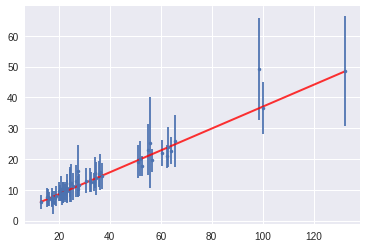

In [686]:
def lnlikelin(theta, x, y,yerr): # modelo lineal (D) independiente de sigma_sigma, no sirve pero ajusta un ML
    m ,b = theta
    model = m * x +b
    inv_sigma2 = 1.0/np.abs(yerr)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
nll = lambda *args: -lnlikelin(*args)
result = op.minimize(nll, [1., 1.], args=(x, y, yerr))
m_ml, b_ml = result["x"]
print(result["x"])
xl = np.array([x.min(), x.max()])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.errorbar(x,y,yerr=yerr,fmt='.')

In [687]:
def lnlikelin(theta, x, y,yerr):# modelo lineal (D,wstd) independiente de sigma_sigma
    m ,b,f = theta
    model = m * x + b + f * yerr
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b,f = theta
    if -2 < m < 2 and -20 < b < 20 and -20 < f < 20:
        return 0.0
    return -np.inf
# Posterior probability
def lnproblin(theta, x, y,yerr):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y,yerr)

In [688]:
nll = lambda *args: -lnlikelin(*args)
result = op.minimize(nll, [1.]*3, args=(x, y,yerr))
m_ml, b_ml,f_ml = result["x"]
print(result["x"])

[ 0.28880221  0.1568262   0.86068968]


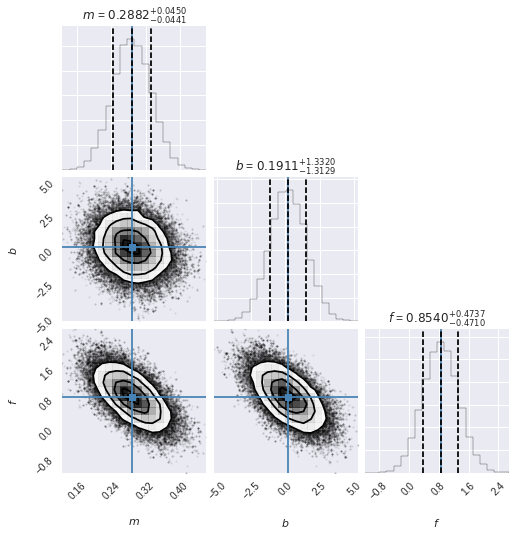

In [689]:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,yerr)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

Rejection rate (%): 0.0
Bayesian p-value: 0.7053


(0, 23.470866504416318)

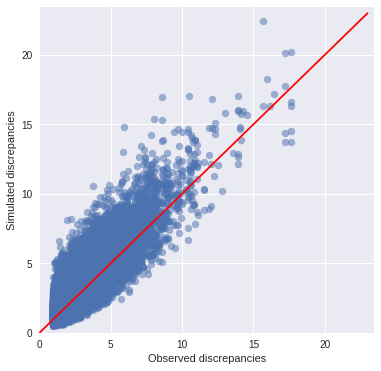

In [690]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
for m,b,f in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr # create a synthetic dataset
    yexp=m*x+b+f*yerr # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

In [673]:
def lnlikelin(theta, x, y,yerr):# modelo lineal (D,wstd) independiente de sigma_sigma
    m ,b,f,g = theta
    model = m * x + b + f * yerr
    inv_sigma2 = 1.0/(yerr**2+(g*x)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b,f,g = theta
    if -2 < m < 2 and -20 < b < 20 and -20 < f < 20 and -20 < g < 20:
        return 0.0
    return -np.inf
# Posterior probability
def lnproblin(theta, x, y,yerr):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y,yerr)

In [674]:
nll = lambda *args: -lnlikelin(*args)
result = op.minimize(nll, [1.]*4, args=(x, y,yerr))
m_ml, b_ml,f_ml,g_ml = result["x"]
print(result["x"])

[  2.88802211e-01   1.56827076e-01   8.60689473e-01  -7.31051705e-09]


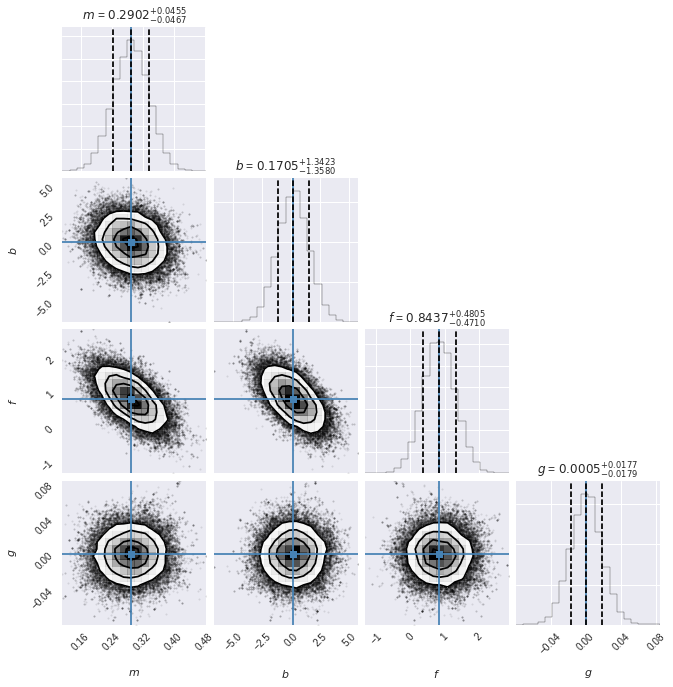

In [675]:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,yerr)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$f$","$g$"],truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

Rejection rate (%): 0.0
Bayesian p-value: 0.73454


(0, 23.907954585645548)

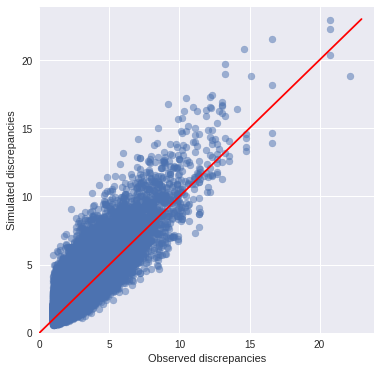

In [676]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
for m,b,f,g in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr # create a synthetic dataset
    yexp=m*x+b+f*yerr # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

In [465]:
m,b,f,g = meanest
ymc=m*x+b+f*yerr

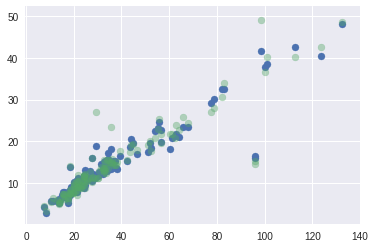

In [469]:
plt.scatter(x,ymc)
plt.scatter(x,y,alpha=0.4)

### Modelo de errores por cuadratura

No reproduce la varianza pero produce una posterior predictive que posiblemente pase un test AD (hay que hacerlo). Si no lo pasa, intentar con peso estadistico por cuadratura, pero no creo que sea necesario.

In [855]:
def lnlikelin(theta, x, y,yerr):# Prueba sugerida por S. Torres
    m ,b,f = theta
    model = m * x**2 + b + f * x
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b,f = theta
    if 0 < m < 10 and -50 < b < 50 and -20 < f < 20:
        return 0.0
    return -np.inf
# Posterior probability
def lnproblin(theta, x, y,yerr):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y,yerr)

In [856]:
filt=np.array(em)>6
filt.sum()

2650

In [858]:
for i in range(5,19): # sin el yerr al cuadrado da buenos resultados para el b, hay que comparar los y_sim
    filt=np.array(em)>i
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    #yerr=np.array(wstd)[filt] # wstd
    yerr=np.array(bootsig)[filt]
    nll = lambda *args: -lnlikelin(*args)
    result = op.minimize(nll, [1.]*3, args=(x, y,yerr))
    m_ml, b_ml,f_ml = result["x"]
    print(result["x"])

[-0.00097761 -0.00438486  0.42168022]
[-0.00097761 -0.00438486  0.42168022]
[-0.00100325 -0.03690268  0.42718093]
[-0.00100539  0.03168445  0.42849985]
[-0.0009644   0.19707063  0.4236681 ]
[-0.00105548  0.05621773  0.43183291]
[-0.00098864  0.16765992  0.4275021 ]
[-0.00096767  0.112103    0.42903093]
[-0.00111687 -0.00923405  0.43938426]
[-0.00119454  0.10275867  0.43675494]
[-0.00147362 -0.16819239  0.45942929]
[-0.0017636  -0.21705527  0.4713072 ]
[-0.00180537 -0.29743018  0.47454804]
[-0.00214684 -0.2642464   0.48957067]
[-0.00184177 -0.25039271  0.481727  ]


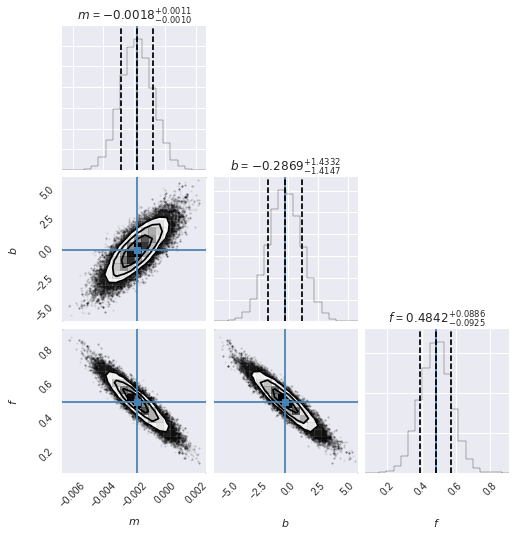

In [859]:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,yerr)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

In [866]:
mest=samples[:,0]
best=samples[:,1]
fest=samples[:,2]
sig=best-(fest**2/(4*mest))
print(100*(sig<0).sum()/len(sig),sig.mean())

4.2 51.86645567


In [867]:
for i in range(5,19): # errores sistematicos bastante grandes
    filt=np.array(em)>i
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    #yerr=np.array(wstd)[filt] # wstd
    yerr=np.array(bootsig)[filt]
    nll = lambda *args: -lnlikelin(*args)
    result = op.minimize(nll, [1.]*3, args=(x, y,yerr))
    m_ml, b_ml,f_ml = result["x"]
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,yerr)) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    mest=samples[:,0]
    best=samples[:,1]
    fest=samples[:,2]
    sig=best-(fest**2/(4*mest))
    print(100*(sig<0).sum()/len(sig),sig.mean())

0.0 46.3682971319
0.0 46.0989995457
0.0 46.7974505116
0.0144444444444 49.6011994681
0.00666666666667 47.0149227947
0.0822222222222 48.2645550322
0.333333333333 66.662236556
0.512222222222 50.1605756815
0.716666666667 43.7556752233
0.603333333333 39.0656415303
0.313333333333 35.8000146165
0.53 31.5619784579
0.496666666667 31.7360207015
4.17555555556 40.7018898269


In [869]:
np.sqrt(2*sig*mest)+np.sqrt(2*sig*(best-sig))

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [ ]:
best

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


Rejection rate (%): 0.030009002700810243
Bayesian p-value: 0.0


(0, 1263.5467848020585)

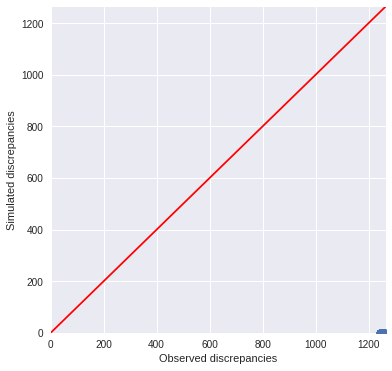

In [730]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
for m,b,f in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=np.sqrt(AAA[:,0]*x+AAA[:,1]+AAA[:,2]*x**2) # create a synthetic dataset
    yexp=np.sqrt(m*x+b+f*x**2) # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)|np.isnan(yexp)|np.isnan(y_sim)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

In [816]:
(sig2>0).sum()

0

In [832]:
def lnlikelin(theta, x, y,yerr):# modelo lineal (D,wstd) independiente de sigma_sigma
    m ,b = theta
    model = m * x**2 + b**2
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b = theta
    if 0 < m < 10 and 0 < b < 50:
        return 0.0
    return -np.inf
# Posterior probability
def lnproblin(theta, x, y,yerr):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y,yerr)

In [851]:
for i in range(5,20): # sin el yerr al cuadrado da buenos resultados para el b, hay que comparar los y_sim
    filt=np.array(em)>i
    filt.sum()
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    #yerr=np.array(wstd)[filt] # wstd
    yerr=np.array(bootsig)[filt]
    y=y**2
    #yerr=yerr**2
    nll = lambda *args: -lnlikelin(*args)
    result = op.minimize(nll, [1.]*2, args=(x, y,yerr))
    m_ml, b_ml = result["x"]
    print(i,result["x"])

5 [ 0.11459129  3.72369769]
6 [ 0.11819574 -3.63492447]
7 [ 0.12062696  4.19303641]
8 [ 0.11997778  5.03555688]
9 [ 0.12165274  4.77928378]
10 [ 0.12318397  4.78984471]
11 [ 0.12621999  4.61753946]
12 [ 0.12486379  4.65216064]
13 [ 0.11870768  4.90208896]
14 [ 0.11583106  5.2363353 ]
15 [ 0.10819894  5.45058052]
16 [ 0.10320223 -5.7183878 ]
17 [ 0.09713047  6.09123076]
18 [ 0.11085641  5.66451287]
19 [ 0.14683719 -3.71556699]


In [845]:
filt=np.array(em)>14
print(filt.sum())
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
#yerr=np.array(wstd)[filt] # wstd
yerr=np.array(bootsig)[filt]
y=y**2
#yerr=yerr**2
nll = lambda *args: -lnlikelin(*args)
result = op.minimize(nll, [1.]*2, args=(x, y,yerr))
m_ml, b_ml = result["x"]
print(result["x"])

337
[ 0.11583106  5.2363353 ]


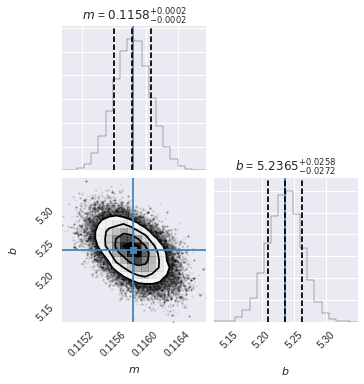

In [846]:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,yerr)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$"],truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

Rejection rate (%): 0.0
Bayesian p-value: 0.0


(0, 44.324272584795715)

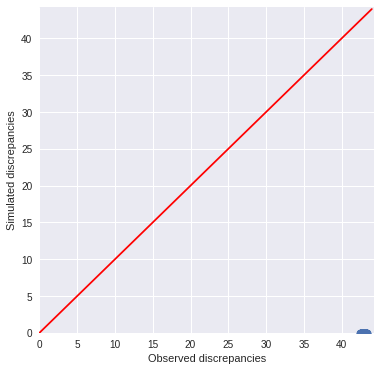

In [847]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
for m,b in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=np.sqrt(AAA[:,0]*x**2+AAA[:,1]**2) # create a synthetic dataset
    yexp=np.sqrt(m*x**2+b**2) # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)|np.isnan(yexp)|np.isnan(y_sim)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

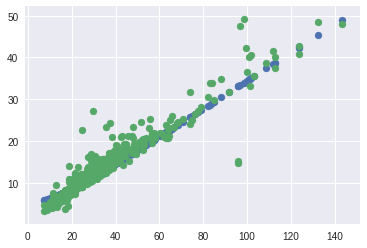

In [848]:
plt.scatter(x,y_sim)
plt.scatter(x,y)

### Anderson-Darling

Pruebas

In [189]:
k=0
myr=1000
for i in range(myr):
    p1=np.sort(np.random.normal(2.01,0.2,1000))
    p2=np.sort(np.random.normal(2,0.2,1000))
    p3=np.sort(np.random.normal(2,0.2,1000))
    ksan=ss.anderson_ksamp([p1,p2,p3])
    if ksan.statistic > ksan.significance_level:
        k+=1
k/myr

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


0.536

In [190]:
ss.anderson_ksamp([p1,p2,p3])

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


Anderson_ksampResult(statistic=-0.1686782783093777, critical_values=array([ 0.44925884,  1.3052767 ,  1.9434184 ,  2.57696569,  3.41634856]), significance_level=0.4839994150713497)

(array([   3.,    4.,   26.,   81.,  185.,  256.,  244.,  130.,   56.,   15.]),
 array([ 1.23908141,  1.37235938,  1.50563735,  1.63891533,  1.7721933 ,
         1.90547127,  2.03874925,  2.17202722,  2.3053052 ,  2.43858317,
         2.57186114]),
 <a list of 10 Patch objects>)

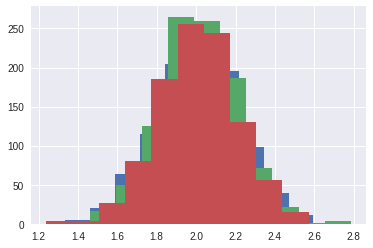

In [191]:
plt.hist(p1)
plt.hist(p2)
plt.hist(p3)

In [192]:
ss.anderson_ksamp([y,y_sim,yexp])

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


Anderson_ksampResult(statistic=7.7176953726283273, critical_values=array([ 0.44925884,  1.3052767 ,  1.9434184 ,  2.57696569,  3.41634856]), significance_level=7.971553219922106e-05)

If A2 is larger than these critical values then for the corresponding significance level, the null hypothesis that the data come from the chosen distribution can be rejected.